# Capítulo 3 - Classificação

Neste capítulo, usaremos o conjunto de dados MNIST, que é um conjunto de 70.000 pequenas imagens de dígitos escritos à mão por alunos do ensino médio e funcionários do US Center Bureau. Cada imagem é identificada com o dígito que representa. Este conjunto foi estudado tanto que é frequentemente chamado de “Hello World” do Machine Learning: sempre que as pessoas apresentam um novo algoritmo de classificação, elas ficam curiosas para ver como será o desempenho no MNIST.

In [1]:
# Importando bibliotecas
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import sklearn
import sys

# Setando algumas configurações e avisos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "capitulo-3"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figuras", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


# Criando função para salvamento de figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Salvando Figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 3.1 MNIST Dataset

O Scikit-Learn oferece muitas funções auxiliares para baixar conjuntos de dados populares. MNIST é um deles. O código a seguir busca o conjunto de dados MNIST:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Os conjuntos de dados carregados pelo Scikit-Learn geralmente têm uma estrutura de dicionário semelhante, incluindo:
- Uma chave DESCR que descreve o conjunto de dados 
- Uma chave `data` contendo uma matriz com uma linha por instância e uma coluna por _feature_
- Uma chave `taget` contendo uma matriz com os _labels_ (rótulos)

Vejamos estes arrays:

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

y.shape

Existem 70.000 imagens e cada imagem tem 784 recursos. Isso ocorre porque cada imagem tem 28 × 28 pixels, e cada recurso simplesmente representa a intensidade de um pixel, de 0 (branco) a 255 (preto). Vamos dar uma olhada em um dígito do conjunto de dados. Tudo que você precisa fazer é pegar o vetor de recurso de uma instância, remodelá-lo para uma matriz 28 × 28 e exibi-lo usando a função `imshow()` do Matplotlib:

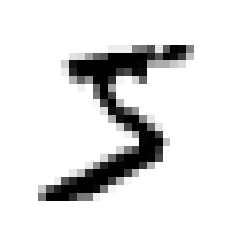

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Selecionando a primeira instância da matriz X
some_digit = X[0]

# Transformando a linha com 784 elementos em uma matriz 28x28
some_digit_image = some_digit.reshape(28, 28)

# Imprimindo a imagem da instância escolhida
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

Isto se parece com um número 5, para confirmarmos se é isto mesmo, analisaremos o rótulo (_label_):

In [5]:
y[0]

'5'

Observe que o rótulo é uma string. Preferimos números, então vamos converter y em inteiros:

In [6]:
y = y.astype(np.uint8)

Podemos então criar uma função que imprima um único dígito, ou até uma função que imprima diversos dígitos:

In [7]:
# Função que imprime um único dígito
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# Função que imprime uma matriz de dígitos
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    
    n_empty = n_rows * images_per_row - len(instances)
    
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

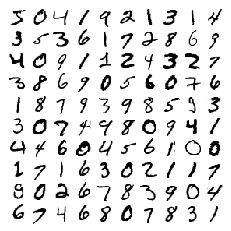

<Figure size 648x648 with 0 Axes>

In [9]:
# Testando a função plot_digits com 100 dígitos, sendo 10 por linha
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

plt.figure(figsize=(9,9))
plt.show()

Você sempre deve criar um conjunto de teste e colocá-lo de lado antes de inspecionar os dados de perto. O conjunto de dados MNIST já está dividido em um conjunto de treinamento (as primeiras 60.000 imagens) e um conjunto de teste (as últimas 10.000 imagens):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Treinando um Classificado Binário

Vamos simplificar o problema por enquanto e tentar identificar apenas um dígito - por exemplo, o número 5. Este "detector de 5" será um exemplo de um classificador binário, capaz de distinguir entre apenas duas classes, 5 e não-5. Vamos criar os vetores de destino para esta tarefa de classificação:

In [11]:
# Recebe True para todos os 5, e False para os outros dígitos 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Ok, agora vamos escolher um classificador e treiná-lo. Um bom lugar para começar é com um classificador _Stochastic Gradient Descent (SGD)_, usando a classe SGDClassifier do Scikit-Learn. Este classificador tem a vantagem de ser capaz de manipular conjuntos de dados muito grandes com eficiência. Isso ocorre em parte porque o SGD lida com instâncias de treinamento de forma independente, uma de cada vez. Vamos criar um SGDClassifier e treiná-lo em todo o conjunto de treinamento:

In [12]:
from sklearn.linear_model import SGDClassifier

# Inicializando e ajustando o SGDClassifier aos dados de treino
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
# Predizendo para o X[0] que é um dígito 5
sgd_clf.predict([some_digit])

array([ True])

O classificador adivinhou que esta imagem representa um 5 (Verdadeiro). Parece que acertou neste caso em particular! Agora, vamos avaliar o desempenho deste modelo.

## 3.3 Medidas de Desempenho

Avaliar um classificador costuma ser significativamente mais complicado do que avaliar um regressor, portanto, passaremos grande parte deste capítulo neste tópico. Existem muitas medidas de desempenho disponíveis.

### 3.3.1 Medindo a Precisão Usando Validação Cruzada

Vamos usar a função `cross_val_score()` para avaliar seu modelo SGDClassifier usando validação cruzada K-fold, com três _folds_. Lembre-se de que a validação cruzada K-fold significa dividir o conjunto de treinamento em K-folds (neste caso, três), e então fazer previsões e avaliá-las em cada _fold_ usando um modelo treinado nas dobras restantes.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Precisão acima de 93% em todas os _folds_ de validação cruzada? Isso parece incrível, não é? Bem, antes que você fique muito animado, vamos dar uma olhada em um classificador muito burro que apenas classifica cada imagem na classe "não-5":

In [15]:
from sklearn.base import BaseEstimator

# Criando uma função que sempre classifica o dígito como não-5
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Testaremos agora a precisão deste modelo então:

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Isso mesmo, tem mais de 90% de precisão! Isso ocorre simplesmente porque apenas cerca de 10% das imagens são 5s, então, se você sempre adivinhar que uma imagem não é um 5, você estará certo cerca de 90% das vezes. Isso demonstra por que a precisão geralmente não é a medida de desempenho preferida para classificadores, especialmente quando você está lidando com conjuntos de _skewed_ datasets (ou seja, quando algumas classes são muito mais frequentes do que outras).

### 3.3.2 Matriz de Confusão

Uma maneira muito melhor de avaliar o desempenho de um classificador é examinar a matriz de confusão. A ideia geral é contar o número de vezes que as instâncias da classe A são classificadas como classe B. Por exemplo, para saber o número de vezes que o classificador confundiu imagens de 5s com 3s, você procuraria na 5ª linha e na 3ª coluna do matriz de confusão.

Para calcular a matriz de confusão, primeiro você precisa ter um conjunto de predições, para que possam ser comparadas aos alvos reais. Você poderia fazer a predição no conjunto de teste, mas vamos mantê-lo intocado por enquanto (lembre-se de que você deseja usar o conjunto de teste apenas no final do seu projeto, assim que tiver um classificador que está pronto para lançar). Em vez disso, você pode usar a função `cross_val_predict()`:

In [17]:
from sklearn.model_selection import cross_val_predict

# Realizando a validação cruzada no modelo SGDClassifier
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Assim como a função `cross_val_score()`, `cross_val_predict()` realiza validação cruzada K-fold, mas em vez de retornar as pontuações de avaliação, ela retorna as previsões feitas em cada _fold_ teste. Isso significa que você obtém uma previsão limpa para cada instância no conjunto de treinamento ("limpo" significa que a previsão é feita por um modelo que nunca viu os dados durante o treinamento). 

Agora você está pronto para obter a matriz de confusão usando a função `confused_matrix()`. Basta passar as classes de destino (y_train_5) e as classes previstas (y_train_pred):

In [18]:
from sklearn.metrics import confusion_matrix

# Gerando a matriz de confusão do dataset de treino
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Cada linha em uma matriz de confusão representa uma classe atual, enquanto cada coluna representa uma classe predita. 

A primeira linha desta matriz considera imagens não são 5s (a classe negativa): 53.892 delas foram classificadas corretamente como não 5s (são chamadas de verdadeiro negativo), enquanto as restantes 687 foram classificadas erroneamente como 5s (falsos positivos). 

A segunda linha considera as imagens que são 5s (a classe positiva): 1.891 foram erroneamente classificadas como não-5s (falsos negativos), enquanto as 3.530 restantes foram classificadas corretamente como 5s (verdadeiros positivos). 

Um classificador perfeito teria apenas verdadeiros positivos e verdadeiros negativos, então sua matriz de confusão teria valores diferentes de zero apenas em sua diagonal principal (superior esquerdo para inferior direito):

In [19]:
# Mostrando como seria uma matriz de confusão "perfeita"
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 3.3.3 Precisão e Revocação

A matriz de confusão fornece muitas informações, mas às vezes você pode preferir uma métrica mais concisa. Um aspecto interessante de se observar é a precisão do classificador para as predições positivas.

A precisão é normalmente usada junto com outra métrica chamada recall, também chamada de sensibilidade ou revocação.

O Scikit-Learn fornece várias funções para calcular as métricas do classificador, incluindo precisão e revocação:

In [20]:
from sklearn.metrics import precision_score, recall_score

# Calculando a precisão do modelo formulado no dataset de treino
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
# Calculando a revocação do modelo formulado no dataset de treino
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Muitas vezes, é conveniente combinar precisão e revocação em uma única métrica chamada F1-score. Muito utilizado se você precisa de uma maneira simples de comparar dois classificadores. O F1-Score é a média harmônica de precisão com a revocação. Infelizmente, você não pode ter as duas coisas: aumentar a precisão reduz o recall e vice-versa. Isso é chamado de _precision/recall tradeoff_.

In [22]:
from sklearn.metrics import f1_score

# Calculando o F1-Score do modelo formulado no dataset de treino
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 Precisão/Revocação _Tradeoff_

Para entender este _tradeoff_, vamos ver como o SGDClassifier toma suas decisões de classificação. Para cada instância, ele calcula uma pontuação com base em uma função de decisão e, se essa pontuação for maior que um limite, ele atribui a instância à classe positiva ou então a atribui à classe negativa.

O Scikit-Learn não permite que você defina o limite diretamente, mas dá acesso às pontuações de decisão que usa para fazer previsões. Em vez de chamar o método `predict()` do classificador, você pode chamar seu método `decision_function()`, que retorna uma pontuação para cada instância e, em seguida, fazer previsões com base nessas pontuações usando qualquer limite que você quiser:

In [23]:
# Retornando o score fornecido para o X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
# Considerando que a predição vai ser positiva se o score for > 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [25]:
y_some_digit_pred

array([ True])

In [26]:
# Considerando que a predição vai ser positiva se o score for > 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Agora, como você decide qual limite usar? Para isso, primeiro você precisará obter as pontuações de todas as instâncias no conjunto de treinamento usando a função `cross_val_predict()` novamente, mas desta vez especificando que deseja retornar pontuações de decisão em vez de previsões:

In [27]:
# Realizando a validação cruzada obtendo a função de decisão como saída
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Agora, com essas pontuações, você pode calcular a precisão e revocação de todos os limites possíveis usando a função `precision_recall_curve()`:

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finalmente, você pode representar graficamente a precisão e a revocação como funções do valor limite usando Matplotlib. Neste caso em especial queremos uma precisão maior ou igual que 90%:

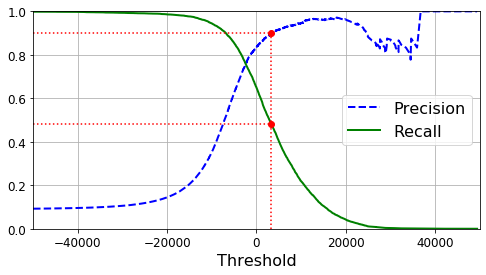

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

Outra maneira de selecionar uma boa compensação de precisão/revocação é traçar a precisão diretamente em relação à revocação:

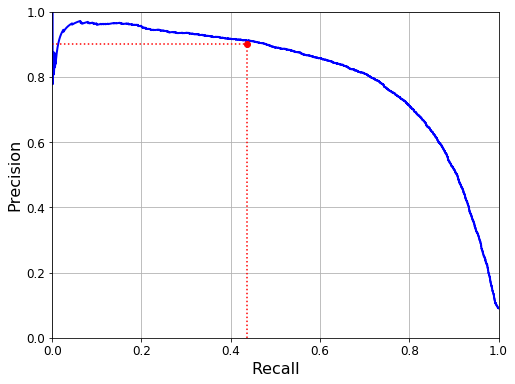

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

Vamos supor que você decida ter como objetivo a precisão de 90%. Você olha o primeiro gráfico e descobre que precisa usar um limite de cerca de 8.000. Para ser mais preciso, você pode pesquisar o limite mais baixo que fornece pelo menos 90% de precisão (`np.argmax()` nos dará o primeiro índice do valor máximo, que neste caso significa o primeiro valor True):

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [32]:
threshold_90_precision

3370.0194991439557

Para fazer previsões (no conjunto de treinamento por enquanto), em vez de chamar o método `predict()` do classificador, você pode apenas executar este código:

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Vamos então checar a precisão e revocação para estas predições:

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Ótimo, você tem um classificador de precisão de 90%! Como você pode ver, é bastante fácil criar um classificador com praticamente qualquer precisão desejada: basta definir um limite alto o suficiente e pronto. Um classificador de alta precisão não é muito útil se sua revocação for muito baixa!

### 3.3.4 Cuvas ROC

A curva _receiver operating characteristic_ (ROC) é outra ferramenta comumente usada com classificadores binários. É muito semelhante à curva de precisão/revocação, mas em vez de traçar a precisão versus revocação, a curva ROC traça a taxa de verdadeiro positivo (outro nome para a revocação) contra a taxa de falso positivo. O FPR é a proporção de ocorrências negativas classificadas incorretamente como positivas. É igual a um menos a taxa negativa verdadeira, que é a proporção de ocorrências negativas que são classificadas corretamente como negativas. O TNR também é chamado de especificidade. Portanto, a curva ROC representa a sensibilidade (revocação) versus 1 - especificidade.

Para plotar a curva ROC, você primeiro precisa calcular o TPR e FPR para vários valores, usando a função `roc_curve()`:

In [36]:
from sklearn.metrics import roc_curve

# Calculando o FPR e TPR para plotar a curva ROC
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

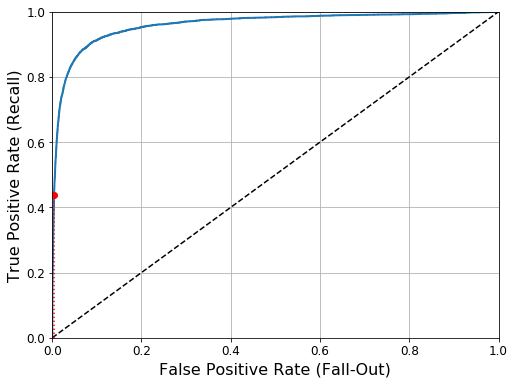

In [37]:
# Função que plota a curva ROC, utilizando o FPR e o TPR
def plot_roc_curve(fpr, tpr, label=None):
    # Plotando as linhas do FPR e TPR
    plt.plot(fpr, tpr, linewidth=2, label=label)
    
    # Plotando a diagonal tracejada, os rótulos e o grid
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))                         

# Gerando a curva ROC e as linhas auxiliares vermelhas
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.show()

Mais uma vez, há uma compensação: quanto maior o recall (TPR), mais falsos positivos (FPR) o classificador produz. A linha pontilhada representa a curva ROC de um classificador puramente aleatório; um bom classificador fica o mais longe possível dessa linha (em direção ao canto superior esquerdo). Uma maneira de comparar os classificadores é medir a área sob a curva (AUC). Um classificador perfeito terá um ROC AUC igual a 1, enquanto um classificador puramente aleatório terá um ROC AUC igual a 0,5. O Scikit-Learn fornece uma função para calcular o ROC AUC:

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Como a curva ROC é tão semelhante à curva de precisão/recall (ou PR), você pode se perguntar como decidir qual usar. Como regra geral, você deve preferir a curva PR sempre que a classe positiva for rara ou quando você se preocupa mais com os falsos positivos do que com os falsos negativos, e a curva ROC caso contrário.


Vamos treinar um `RandomForestClassifier` e comparar sua curva ROC e pontuação ROC AUC com o `SGDClassifier`. Primeiro, você precisa obter pontuações para cada instância no conjunto de treinamento:

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Inicializando o modelo com a Floresta Randômica
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Realizando a predição via validação cruzada com 3 folds
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Para traçar uma curva ROC, você precisa de pontuações, não de probabilidades. Uma solução simples é usar a probabilidade da classe positiva como pontuação:

In [40]:
# score = Probabilidade da classe positiva
y_scores_forest = y_probas_forest[:, 1]

# Gerando a curva ROC usando os scores e o rótulo do treino
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Agora você está pronto para plotar a curva ROC. É útil traçar a primeira curva ROC também para ver como eles se comparam:

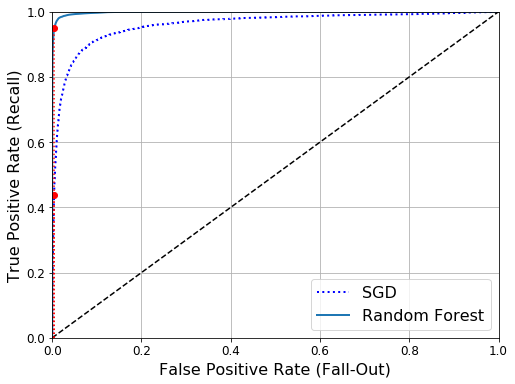

In [41]:
plt.figure(figsize=(8, 6))

# Plotando a curva ROC do SGDClassifier
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")

# Plotando a curva ROC do RandomForestClassifier
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

Como você pode ver, a curva ROC do `RandomForestClassifier` parece muito melhor do que a do `SGDClassifier`: ela se aproxima muito do canto superior esquerdo. Como resultado, sua pontuação ROC AUC também é significativamente melhor:

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

As pontuações de precisão e recall são respectivamente 99,0% de precisão e 86,6% de recall:

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

# Calculando a precisão
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [44]:
# Calculando a revocação
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 3.4 Classificação Multiclasse

Enquanto os classificadores binários distinguem entre duas classes, os classificadores multiclasse (também chamados de classificadores multinomiais) podem distinguir entre mais de duas classes.

Alguns algoritmos (como classificadores Random Forest ou classificadores naive Bayes) são capazes de lidar com várias classes diretamente. Outros (como classificadores Support Vector Machine ou Lineares) são estritamente binários. No entanto, existem várias estratégias que você pode usar para realizar a classificação multiclasse usando vários classificadores binários.

Por exemplo, uma maneira de criar um sistema que pode classificar as imagens de dígitos em 10 classes (de 0 a 9) é treinar 10 classificadores binários, um para cada dígito (um detector 0, um detector 1, um detector 2 , e assim por diante). Então, quando quiser classificar uma imagem, você obtém a pontuação de decisão de cada classificador para aquela imagem e seleciona a classe cujo classificador produz a pontuação mais alta. Isso é chamado de estratégia _one-versus-all_ (OvA) (também chamada de _one-versus-the-rest_).

Outra estratégia é treinar um classificador binário para cada par de dígitos: um para distinguir 0s e 1s, outro para distinguir 0s e 2s, outro para 1s e 2s e assim por diante. Isso é chamado de estratégia _one-versus-one_ (OvO). Se houver N classes, você precisará treinar N × (N - 1) / 2 classificadores.

O Scikit-Learn detecta quando você tenta usar um algoritmo de classificação binária para uma tarefa de classificação multiclasse e executa o OvA automaticamente (exceto para classificadores SVM para os quais usa o OvO). Vamos tentar isso com o `SVM`:

In [45]:
from sklearn.svm import SVC

# Definindo e ajustando o modelo SVM 
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

# Gerando a predição do modelo
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Este código treina o `SVM` no conjunto de treinamento usando as classes de destino originais de 0 a 9 (y_train), em vez das classes de destino 5 versus todas (y_train_5). Em seguida, ele faz uma previsão (uma correta neste caso). Nos bastidores, o Scikit-Learn realmente treinou 10 classificadores binários, obteve suas pontuações de decisão para a imagem e selecionou a classe com a pontuação mais alta.

Para ver que este é realmente o caso, você pode chamar o método `decision_function()`. Em vez de retornar apenas quem atingiu a maior pontuação, agora retorna as 10 pontuações, uma por classe:

In [46]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

A pontuação mais alta é, de fato, aquela correspondente à classe 5:

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
svm_clf.classes_[5]

5

Se você deseja forçar o ScikitLearn a usar _one-versus-one_ ou _one-versus-all_, você pode usar as classes `OneVsOneClassifier` ou `OneVsRestClassifier`. Simplesmente crie uma instância e passe um classificador binário para seu construtor. Por exemplo, este código cria um classificador multiclasse usando a estratégia OvA, com base em um `SVM`:

In [50]:
from sklearn.multiclass import OneVsRestClassifier

# Criando e ajustando uma estratégia OvA com um modelo SVM
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

# Gerando a predição do modelo criado
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovr_clf.estimators_)

10

Ajustando e predizendo agora com um `SGDClassifier`: 

In [52]:
# Ajustando ao modelo
sgd_clf.fit(X_train, y_train)

# Gerando a predição do modelo criado
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [53]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 Análise de Erro

Vamos supor que você encontrou um modelo promissor e deseja encontrar maneiras de melhorá-lo. Uma maneira de fazer isso é analisar os tipos de erros que ele comete.

Primeiro, você pode examinar a matriz de confusão. Você precisa fazer previsões usando a função `cross_val_predict()` e, em seguida, chamar a função `confused_matrix()`, assim como você fez antes:

In [55]:
# Gerando a predição através da validação cruzada com 3 folds
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# Plotando a matriz de confução
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

São muitos números. Muitas vezes é mais conveniente olhar para uma representação de imagem da matriz de confusão, usando a função `matshow()` do Matplotlib:

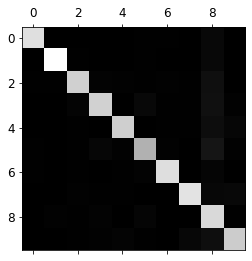

In [56]:
# Plotando a matriz de confusão em um gráfico de calor
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Esta matriz de confusão parece bastante boa, já que a maioria das imagens está na diagonal principal, o que significa que foram classificadas corretamente. O 5s parece um pouco mais escuro do que os outros dígitos, o que pode significar que há menos imagens de 5s no conjunto de dados ou que o classificador não tem um desempenho tão bom nos 5s quanto nos outros dígitos. Na verdade, você pode verificar se são ambos os casos.

Vamos focar o gráfico nos erros. Primeiro, você precisa dividir cada valor na matriz de confusão pelo número de imagens na classe correspondente, para que você possa comparar as taxas de erro em vez do número absoluto de erros (o que faria com que classes abundantes parecessem injustamente ruins):

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

norm_conf_mx = conf_mx / row_sums

Agora vamos preencher a diagonal com zeros para manter apenas os erros e representar o resultado:

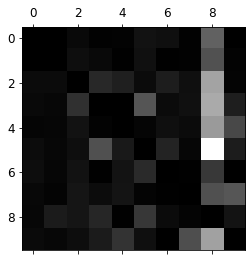

In [58]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Agora você pode ver claramente os tipos de erros que o classificador comete. Lembre-se de que as linhas representam as classes reais, enquanto as colunas representam as classes previstas. 

A coluna da classe 8 é bem clara, o que indica que muitas imagens foram classificadas incorretamente como 8s. No entanto, a linha para a classe 8 não é tão ruim, informando que 8s reais em geral são classificados corretamente como 8s.

A análise da matriz de confusão geralmente pode fornecer insights sobre maneiras de melhorar seu classificador. Olhando para esse gráfico, parece que seus esforços devem ser gastos na redução dos falsos 8s. Por exemplo, você pode tentar reunir mais dados de treinamento para dígitos que se parecem com 8s (mas não são) para que o classificador possa aprender a distingui-los dos 8s reais. Ou você poderia projetar novos recursos que ajudariam o classificador.

Analisar erros individuais também pode ser uma boa maneira de obter insights sobre o que seu classificador está fazendo e por que está falhando, mas é mais difícil e demorado. Por exemplo, vamos traçar exemplos de 3s e 5s:

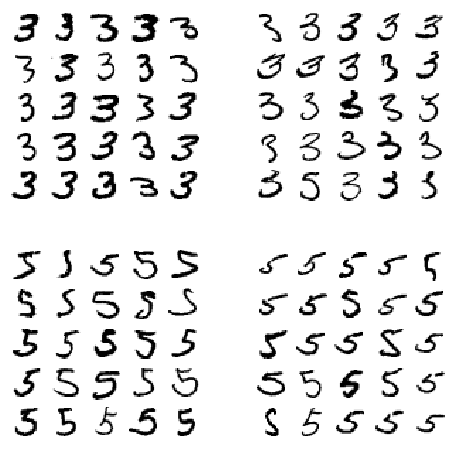

In [59]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# Gerando 4 plotagens de 5x5, cada um com 25 dígitos
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Os dois blocos 5 × 5 à esquerda mostram dígitos classificados como 3s e os dois blocos 5 × 5 à direita mostram imagens classificadas como 5s. Alguns dos dígitos que o classificador errou (ou seja, nos blocos inferior esquerdo e superior direito) estão tão mal escritos que até mesmo um humano teria problemas para classificá-los (por exemplo, o 5 no primeira linha e 2ª coluna verdadeiramente parece um mal escrito 3). 

No entanto, a maioria das imagens classificadas incorretamente parecem erros óbvios para nós, e é difícil entender por que o classificador cometeu os erros que cometeu. O motivo é que usamos um SGDClassifier simples, que é um modelo linear. Tudo o que ele faz é atribuir um peso por classe a cada pixel e, quando vê uma nova imagem, apenas soma as intensidades de pixel ponderadas para obter uma pontuação para cada classe. Portanto, como os 3s e os 5s diferem apenas por alguns pixels, este modelo os confundirá facilmente.

A principal diferença entre 3s e 5s é a posição da pequena linha que une a linha superior ao arco inferior. Se você desenhar um 3 com a junção ligeiramente deslocada para a esquerda, o classificador pode classificá-lo como um 5 e vice-versa. Em outras palavras, esse classificador é bastante sensível ao deslocamento e rotação da imagem. Portanto, uma maneira de reduzir a confusão 3/5 seria pré-processar as imagens para garantir que fiquem bem centralizadas e não muito giradas. Isso provavelmente ajudará a reduzir outros erros também.

# 3.6 Classificação Multilabel

Até agora, cada instância sempre foi atribuída a apenas uma classe. Em alguns casos, você pode querer que seu classificador produza várias classes para cada instância. Por exemplo, considere um classificador de reconhecimento de rosto: o que ele deve fazer se reconhecer várias pessoas na mesma imagem? É claro que deve anexar um rótulo por pessoa que reconhece. Digamos que o classificador foi treinado para reconhecer três faces, Alice, Bob e Charlie; então, quando for mostrada uma imagem de Alice e Charlie, ele deve imprimir [1, 0, 1] (significando “Alice sim, Bob não, Charlie sim”). Esse sistema de classificação que produz várias tags binárias é chamado de sistema de classificação de múltiplos rótulos (_multilabel_).

Ainda não entraremos em reconhecimento facial, mas vamos ver um exemplo mais simples, apenas para fins de ilustração:

In [60]:
from sklearn.neighbors import KNeighborsClassifier

# Preencha com True se o número for >= 7
y_train_large = (y_train >= 7)

# Preencha com True se o resto do número dividido por 2 é 1 (impar)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

# Inicializa e ajusta um modelo KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Este código cria uma matriz `y_multilabel` contendo dois rótulos de destino para cada imagem de dígito: o primeiro indica se o dígito é grande ou não (7, 8 ou 9) e o segundo indica se é ou não ímpar. As próximas linhas criam uma instância KNeighborsClassifier (que suporta classificação multilabel, mas nem todos os classificadores fazem) e nós a treinamos usando a matriz de múltiplos destinos. Agora você pode fazer uma previsão e perceber que ela produz dois rótulos:

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

O dígito 5 realmente não é grande (Falso) e é ímpar (Verdadeiro).

Existem muitas maneiras de avaliar um classificador multilabel, e selecionar a métrica correta realmente depende do seu projeto. Por exemplo, uma abordagem é medir o F1-score para cada rótulo individual (ou qualquer outra métrica classificadora binária discutida anteriormente) e simplesmente calcular a média. Este código calcula o F1-score médio em todos os rótulos:

In [62]:
# Inicializando a validação cruzada com 3 folds
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# Obtendo a média dos F1-Score do multilabel
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Esta média do F1-Score pressupõe que todos os rótulos são igualmente importantes, o que pode não ser o caso. Em particular, se você tem muito mais fotos de Alice do que de Bob ou Charlie, você pode dar mais peso à pontuação do classificador nas fotos de Alice. Uma opção simples é dar a cada rótulo um peso igual ao seu "suporte" (ou seja, o número de instâncias com aquele rótulo de destino). Para fazer isso, basta definir `average="weighted"` no código anterior.

# 3.7 Classificação Multioutput

O último tipo de tarefa de classificação que vamos discutir aqui é chamada de classificação multioutput. É simplesmente uma generalização da classificação multilabel onde cada rótulo pode ser multiclasse (ou seja, pode ter mais de dois valores possíveis).

Para ilustrar isso, vamos construir um sistema que remove o ruído das imagens. Ele tomará como entrada uma imagem de dígito ruidosa e (esperançosamente) produzirá uma imagem de dígito limpa, representada como um array de intensidades de pixel, assim como as imagens MNIST. Observe que a saída do classificador é multilabel (um rótulo por pixel) e cada rótulo pode ter vários valores (faixas de intensidade de pixel de 0 a 255). É, portanto, um exemplo de sistema de classificação de múltiplas saídas.

Vamos começar criando os conjuntos de treinamento e teste pegando as imagens do MNIST e adicionando ruído às suas intensidades de pixel usando a função `randint()` do NumPy. As imagens alvo serão as imagens originais:

In [63]:
# Inserindo ruído nas imagens do MNIST
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Vamos dar uma olhada em uma imagem do conjunto de teste:

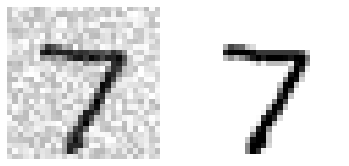

In [64]:
some_index = 0

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

À esquerda está a imagem de entrada com ruído e à direita está a imagem de destino limpa. Agora vamos treinar o classificador e fazê-lo limpar esta imagem:

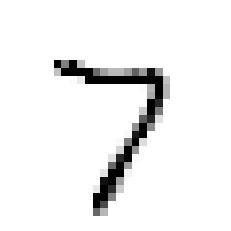

In [65]:
# Ajustando o modelo de classificação KNN
knn_clf.fit(X_train_mod, y_train_mod)

# Gerando a predição do KNN
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)